In [1]:
import os, cv2, re, random
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img,array_to_img
from keras import layers, models, optimizers
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.layers import Conv2D, Activation, MaxPool2D, Flatten, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import load_model
import matplotlib.image as mpimg
import seaborn as sns
import h5py
%matplotlib inline

Using TensorFlow backend.


In [2]:
def prepare_data(list_of_images,dict_names):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = [] # images as arrays
    y = [] # labels
    img_width = 150
    img_height = 150
    for image in list_of_images:
        
        x.append(cv2.resize(cv2.imread(image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
        
        filename = os.path.basename(image)
        
        label = int(dict_names[filename])
        
        y.append(label)
      
    

            
    return x, y

In [3]:
def prepare_data_sign(list_of_images):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = [] # images as arrays
    y = [] # labels
    img_width = 150
    img_height = 150
    for image in list_of_images:
        
        x.append(cv2.resize(cv2.imread(image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
        
        filename = os.path.basename(image).split('.')[0]
        
        label = int(filename)
        
        y.append(label)
      
    

            
    return x, y

In [4]:
#read degroup.csv to dict
f_degroupcsv = open('/Users/lizhen/Desktop/AI_workshop/data/degroup.csv','r')
data_degroupcsv = f_degroupcsv.readlines()
dict_to_save = {}
label_set = set()
for i in data_degroupcsv[1:]:
    split_line = i.split(',')
    img_name = split_line[0]
    img_label = split_line[-1].strip()
    label_set.add(int(img_label))
    dict_to_save[img_name] = img_label
print('number of label:',len(label_set))

IMG_DIR = '/Users/lizhen/Desktop/AI_workshop/data/img/'
SIGNS_DIR = '/Users/lizhen/Desktop/AI_workshop/data/signs/'
origin_img_data_name = [IMG_DIR+i for i in os.listdir('/Users/lizhen/Desktop/AI_workshop/data/img/')]
sign_img_names = [SIGNS_DIR+i for i in os.listdir('/Users/lizhen/Desktop/AI_workshop/data/signs/')]
x_sign,y_sign = prepare_data_sign(sign_img_names)

x_img, y_img = prepare_data(origin_img_data_name,dict_to_save)
x = x_sign+x_img
y = y_sign+y_img
print('img number:',len(origin_img_data_name)+len(sign_img_names))

number of label: 43
img number: 448


In [5]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
x_mid, x_val, y_mid, y_val = train_test_split(x,y, test_size=0.2, random_state=1)
x_train,x_test,y_train,y_test = train_test_split(x_mid,y_mid,test_size=0.25,random_state=1)
y_train = np_utils.to_categorical(y_train,num_classes = 121)
y_val = np_utils.to_categorical(y_val,num_classes = 121)
y_test = np_utils.to_categorical(y_test,num_classes = 121)
print('train samples:',len(x_train))
print('val samples:',len(x_val))
print('test samples:',len(x_test))

train samples: 268
val samples: 90
test samples: 90


In [6]:
nb_train_samples = len(x_train)
nb_validation_samples = len(x_val)
batch_size = 5

In [11]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(121))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
___________________________

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [13]:
train_generator = train_datagen.flow(np.array(x_train), y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(np.array(x_val), y_val, batch_size=batch_size)

In [14]:
visualize_acc_loss = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

Epoch 1/10
53/53 [==============================] - 54s 1s/step - loss: 4.7309 - acc: 0.0453 - val_loss: 4.0725 - val_acc: 0.1111
Epoch 2/10
53/53 [==============================] - 49s 932ms/step - loss: 4.1738 - acc: 0.0830 - val_loss: 3.9479 - val_acc: 0.1111
Epoch 3/10
53/53 [==============================] - 49s 930ms/step - loss: 3.9334 - acc: 0.0830 - val_loss: 3.9065 - val_acc: 0.1000
Epoch 4/10
53/53 [==============================] - 49s 932ms/step - loss: 3.8600 - acc: 0.1019 - val_loss: 3.9074 - val_acc: 0.1111
Epoch 5/10
53/53 [==============================] - 49s 931ms/step - loss: 3.6148 - acc: 0.1434 - val_loss: 3.9717 - val_acc: 0.1222
Epoch 6/10
53/53 [==============================] - 49s 927ms/step - loss: 3.5804 - acc: 0.1359 - val_loss: 4.1940 - val_acc: 0.1111
Epoch 7/10
53/53 [==============================] - 50s 947ms/step - loss: 3.3675 - acc: 0.2114 - val_loss: 4.1969 - val_acc: 0.1444
Epoch 8/10
53/53 [==============================] - 50s 939ms/step - los

In [31]:
model.save('sign.h5')

In [11]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

this image belongs to label: 108
true label of image: 108


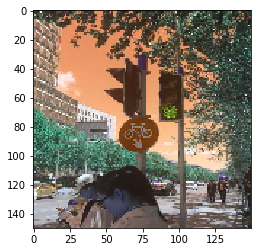

this image belongs to label: 104
true label of image: 35


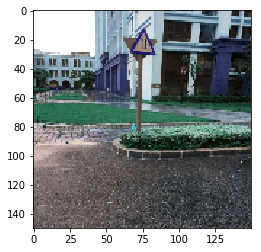

this image belongs to label: 51
true label of image: 51


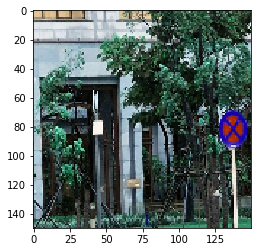

this image belongs to label: 108
true label of image: 100


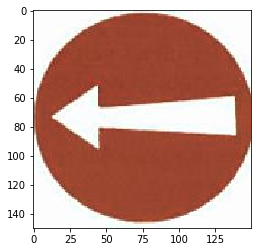

this image belongs to label: 68
true label of image: 68


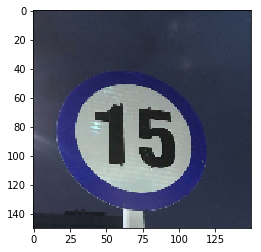

In [63]:
Y_pred = model.predict(np.array(x_val))


for i in range(0,5):
    label_value = max(list(Y_pred[i]))
    index = list(Y_pred[i]).index(label_value)
    print('this image belongs to label:',index)
    print('true label of image:',list(y_val[i]).index(1))
    plt.imshow(x_val[i])    
    plt.show()

In [80]:
model = load_model('sign.h5')
img_path = '/Users/lizhen/Desktop/AI_workshop/data/img/0c94c156f2da1416008550654e8ad150.jpeg'
x = (cv2.resize(cv2.imread(img_path), (150,150), interpolation=cv2.INTER_CUBIC))
x = x.reshape(1,150,150,3)
y = model.predict(np.array(x))
print('true label is:',dict_to_save['0c94c156f2da1416008550654e8ad150.jpeg'])
y = list(y[0])
max_value = max(y)
print('predicted label is:',y.index(max_value))

true label is: 51
predicted label is: 51


## illustration of data augmentation

In [13]:
def imgGen(img,zoom_range=0.0,,horizontal_flip=True,batch_size=1):
    datagen = ImageDataGenerator(
    
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip)
    
    datagen.fit(img)
    i=0
    for img_batch in datagen.flow(img, batch_size=1, shuffle=False):
        for img in img_batch:
            #plt.subplot(330 + 1 + i)
            plt.imshow(img)
            i=i+1    
        if i >= batch_size:
            break
    plt.show()

### zoom_range参数可以让图片在长或宽的方向进行放大，可以理解为某方向的resize，因此这个参数可以是一个数或者是一个list。当给出一个数时，图片同时在长宽两个方向进行同等程度的放缩操作；当给出一个list时，则代表[width_zoom_range, height_zoom_range]，即分别对长宽进行不同程度的放缩。而参数大于0小于1时，执行的是放大操作，当参数大于1时，执行的是缩小操作。
### horizontal_flip的作用是随机对图片执行水平翻转操作，意味着不一定对所有图片都会执行水平翻转，每次生成均是随机选取图片进行翻转


原图显示


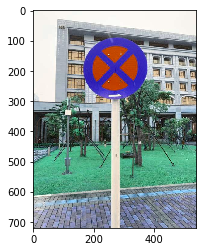

(1, 720, 540, 3)


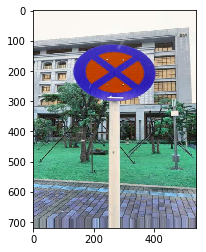

In [15]:
# visualize the image
img = cv2.imread('/Users/lizhen/Desktop/AI_workshop/data/img/0c94c156f2da1416008550654e8ad150.jpeg')
print('原图显示')
plt.imshow(img)
plt.show()
# reshape it to prepare for data generator
img = img.astype('float32')
img /= 255
h_dim = np.shape(img)[0]
w_dim = np.shape(img)[1]
num_channel = np.shape(img)[2]
img = img.reshape(1, h_dim, w_dim, num_channel)
print(img.shape)
# generate images using function imgGen
imgGen(img,zoom_range=0.5,horizontal_flip=True)
